In [1]:
from exp import *

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
dm = DatasetManager('2017',224,'all','2017')

In [4]:
def reload_dataset(dm,seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=0.3,p_affine=1, max_warp=0)

    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name,
                   valid=dm.get_dataset_path('valid_images').name)\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize(imagenet_stats)
    return data

data = reload_dataset(dm)

# Adding attention

### Imports

In [262]:
import geffnet
from geffnet.efficientnet_builder import *

import types

In [263]:
model = geffnet.efficientnet_b3(pretrained=True, as_sequential=True)

In [264]:
DepthwiseSeparableConv and InvertedResidual and True

True

In [265]:
modules = list(m._modules.values())

Hay que ponerle arl en inverted residuals y a depthwiseseparableconvs

## Normal forward funcs

In [201]:
def depthwise_separable_conv_forward(self, x):
        residual = x

        x = self.conv_dw(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.se(x)

        x = self.conv_pw(x)
        x = self.bn2(x)
        x = self.act2(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
            x += residual
        return x

In [266]:
def ir_forward(self, x):
        residual = x

        # Point-wise expansion
        x = self.conv_pw(x)
        x = self.bn1(x)
        x = self.act1(x)

        # Depth-wise convolution
        x = self.conv_dw(x)
        x = self.bn2(x)
        x = self.act2(x)

        # Squeeze-and-excitation
        x = self.se(x)

        # Point-wise linear projection
        x = self.conv_pwl(x)
        x = self.bn3(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
            x += residual
        return x

## Modify model

In [504]:
alpha_initial_value = 0.001



def attn_depthwise_separable_conv_forward(self, x):
        residual = x

        x = self.conv_dw(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.se(x)

        x = self.conv_pw(x)
        x = self.bn2(x)
        x = self.act2(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
#                 Aca no se entra nunca pues hay un solo bloque depthwise que no tiene residual
            print('asd', self.softmaxLayer(x.view(*x.size()[:2], -1)).view_as(x).shape)
            x = x + residual + (residual * self.softmaxLayer(x.view(*x.size()[:2], -1)).view_as(x) * self.alpha)
        
        return x


def change_depthwise_separable_blocks(a_module):
    if not isinstance(a_module,DepthwiseSeparableConv): return
    
#     Add params
    a_module.softmaxLayer = nn.Softmax(2);
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
    
#     Override forward func
    a_module.forward = types.MethodType(attn_depthwise_separable_conv_forward,a_module)


In [505]:
alpha_initial_value = 0.001
def attn_ir_forward(self, x):
        residual = x

        # Point-wise expansion
        x = self.conv_pw(x)
        x = self.bn1(x)
        x = self.act1(x)

        # Depth-wise convolution
        x = self.conv_dw(x)
        x = self.bn2(x)
        x = self.act2(x)

        # Squeeze-and-excitation
        x = self.se(x)

        # Point-wise linear projection
        x = self.conv_pwl(x)
        x = self.bn3(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
            x = x + residual + (residual 
                     * self.softmaxLayer(x.view(*x.size()[:2], -1)).view_as(x) 
                     * self.alpha)
        return x


def change_inverted_residual_blocks(a_module):
    if not isinstance(a_module,InvertedResidual): return
#     Add params
    a_module.softmaxLayer = nn.Softmax(2);
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
    
#     Override forward func
    a_module.forward = types.MethodType(attn_ir_forward,a_module)


In [506]:
# apply_leaf(m, change_inverted_residual_blocks)

In [507]:
def add_attn_geffnet_efficientnet(m):
#     apply_leaf(m, change_depthwise_separable_blocks)
    apply_leaf(m, change_inverted_residual_blocks)

# EfficientNet baseline 

In [354]:
data = reload_dataset(dm)

model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)
random_seed(1,True)
learn = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph])

learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.078011,0.674857,0.353333,0.646667,0.663611,00:06
1,0.843227,0.584031,0.226667,0.773333,0.686389,00:07
2,0.601001,0.525779,0.193333,0.806667,0.644722,00:06
3,0.482347,0.478669,0.186667,0.813333,0.728611,00:07
4,0.437475,0.549164,0.193333,0.806667,0.760000,00:06
5,0.434968,0.451124,0.180000,0.820000,0.784445,00:06
6,0.420520,0.472470,0.186667,0.813333,0.785278,00:06
7,0.364218,0.504475,0.186667,0.813333,0.751389,00:06
8,0.370615,0.474231,0.186667,0.813333,0.785000,00:07
9,0.360966,0.450469,0.166667,0.833333,0.791667,00:06


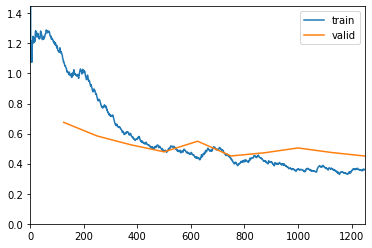

In [261]:
random_seed(1,True)
learn.fit_one_cycle(10, max_lr=slice(3e-03))

# EfficientNet Without Squeeze and Exite

In [574]:
alpha_initial_value = 0.001
def ir_forward_without_se(self, x):
        residual = x

        # Point-wise expansion
        x = self.conv_pw(x)
        x = self.bn1(x)
        x = self.act1(x)

        # Depth-wise convolution
        x = self.conv_dw(x)
        x = self.bn2(x)
        x = self.act2(x)

        # Squeeze-and-excitation
#         x = self.se(x)

        # Point-wise linear projection
        x = self.conv_pwl(x)
        x = self.bn3(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
            x = x + residual
        return x


def remove_se(a_module):
    if not isinstance(a_module,InvertedResidual): return
#     Override forward func
    a_module.forward = types.MethodType(ir_forward_without_se,a_module)

def remove_se_from_model(m):
    apply_leaf(m, remove_se)

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.986143,0.817509,0.240000,0.760000,0.587222,00:05
1,0.783036,0.757923,0.246667,0.753333,0.565556,00:05
2,0.597698,1.090975,0.300000,0.700000,0.408472,00:05
3,0.548487,0.624762,0.186667,0.813333,0.645000,00:05
4,0.540267,0.545202,0.186667,0.813333,0.721667,00:05
5,0.450094,0.502642,0.173333,0.826667,0.746944,00:05
6,0.469598,0.532136,0.226667,0.773333,0.720833,00:05
7,0.430224,0.527832,0.186667,0.813333,0.691389,00:05
8,0.437012,0.470321,0.180000,0.820000,0.758056,00:05
9,0.416746,0.452018,0.180000,0.820000,0.768611,00:05


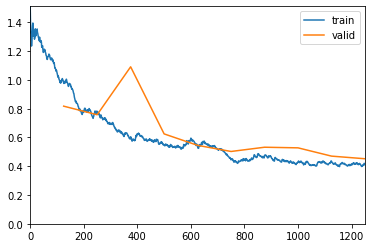

In [575]:
data = reload_dataset(dm)

model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)

remove_se_from_model(model)

random_seed(1,True)
learn = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph])

learn.unfreeze()

random_seed(1,True)
learn.fit_one_cycle(10, max_lr=slice(3e-03))

# EfficientNet Without Squeeze and Exite and with ARL

In [567]:
alpha_initial_value = 0.001
def attn_ir_forward_without_se(self, x):
        residual = x

        # Point-wise expansion
        x = self.conv_pw(x)
        x = self.bn1(x)
        x = self.act1(x)

        # Depth-wise convolution
        x = self.conv_dw(x)
        x = self.bn2(x)
        x = self.act2(x)

        # Squeeze-and-excitation
#         x = self.se(x)

        # Point-wise linear projection
        x = self.conv_pwl(x)
        x = self.bn3(x)

        if self.has_residual:
            if self.drop_connect_rate > 0.:
                x = drop_connect(x, self.training, self.drop_connect_rate)
            x = x + residual + (residual 
                     * self.softmaxLayer(x.view(*x.size()[:2], -1)).view_as(x) 
                     * self.alpha)
        return x


def change_inverted_residual_blocks_without_se(a_module):
    if not isinstance(a_module,InvertedResidual): return
#     Add params
    a_module.softmaxLayer = nn.Softmax(2);
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
    
#     Override forward func
    a_module.forward = types.MethodType(attn_ir_forward_without_se,a_module)


def add_attn_geffnet_efficientnet_without_se(m):
    apply_leaf(m, change_inverted_residual_blocks_without_se)

In [568]:
class Alphas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()

In [569]:
data = reload_dataset(dm)

model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)

add_attn_geffnet_efficientnet_without_se(model)
attn_blocks = [block for block in model.modules() if isinstance(block,InvertedResidual)]

random_seed(1,True)
learn = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph,
                                     partial(Alphas, modules=attn_blocks)
                                     ])

learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.981419,0.770583,0.253333,0.746667,0.575556,00:05
1,0.784706,0.652252,0.206667,0.793333,0.586111,00:06
2,0.617962,0.887215,0.260000,0.740000,0.474722,00:06
3,0.574790,0.657037,0.253333,0.746667,0.665833,00:05
4,0.477176,0.513291,0.200000,0.800000,0.731389,00:06
5,0.450125,0.448872,0.173333,0.826667,0.766111,00:05
6,0.441273,0.493964,0.206667,0.793333,0.752778,00:06
7,0.427240,0.473675,0.206667,0.793333,0.777222,00:05
8,0.427300,0.435875,0.186667,0.813333,0.790833,00:05
9,0.412783,0.432338,0.180000,0.820000,0.795556,00:05


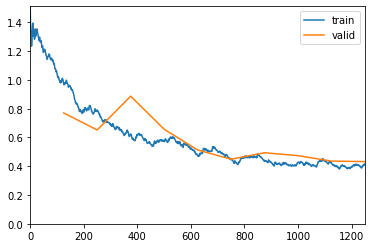

In [570]:
random_seed(1,True)
learn.fit_one_cycle(10, max_lr=slice(3e-03))

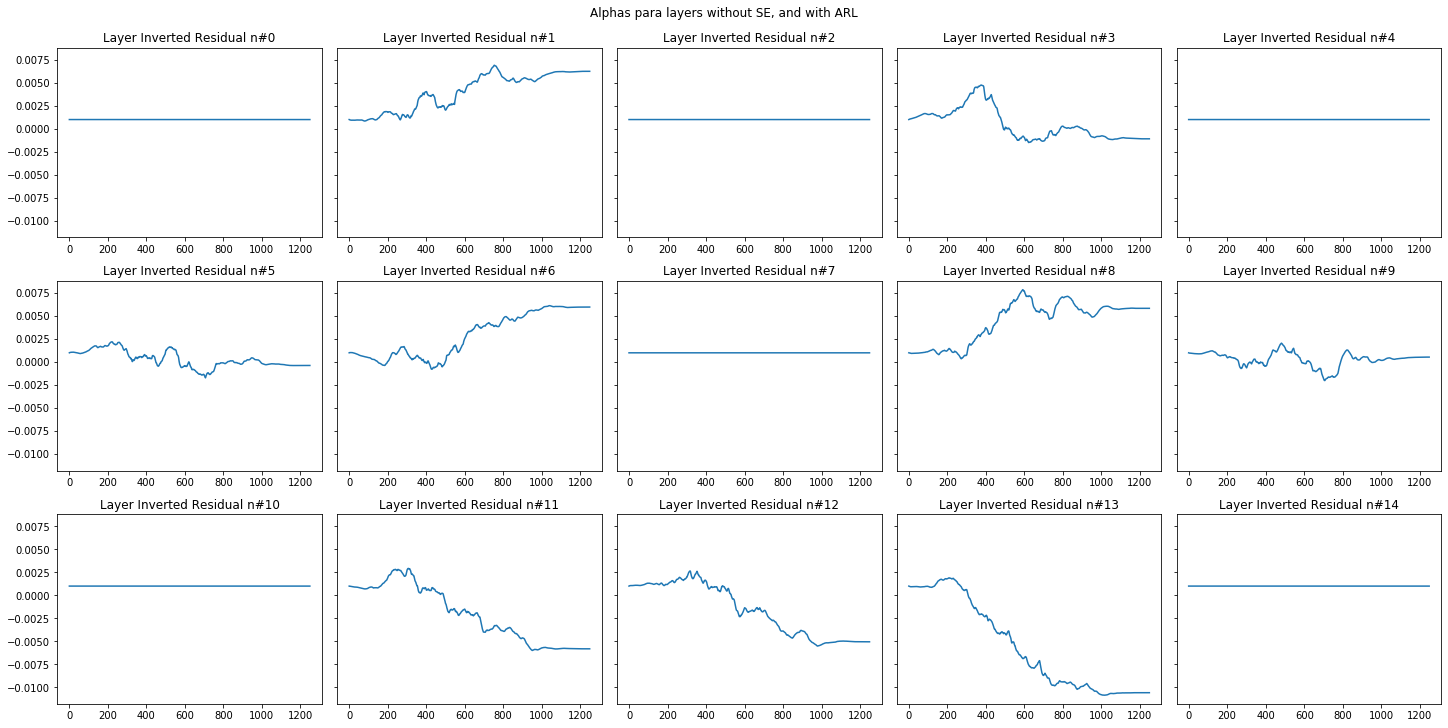

In [571]:
fig,axs = plt.subplots(3,5,figsize=(20,10), constrained_layout=True, sharey=True)

fig.suptitle('Alphas para layers without SE, and with ARL')

for i in range(15):
    axs[i//5][i%5].set_title(f"Layer Inverted Residual n#{i}")
    axs[i//5][i%5].plot(learn.alphas.stats[0][i])
    

# Efficientnet With Squeeze and Exite and With ARL

In [551]:
class Alphas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()

In [552]:
data = reload_dataset(dm)

model = geffnet.efficientnet_b0(pretrained=True, as_sequential=True)

add_attn_geffnet_efficientnet(model)
attn_blocks = [block for block in model.modules() if isinstance(block,InvertedResidual)]

random_seed(1,True)
learn = cnn_learner(data, lambda x: model,pretrained=True, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph,
                                     partial(Alphas, modules=attn_blocks)
                                     ])

learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.078955,0.677547,0.360000,0.640000,0.662778,00:07
1,0.839798,0.588233,0.246667,0.753333,0.687778,00:07
2,0.596223,0.584759,0.193333,0.806667,0.586389,00:07
3,0.469554,0.517532,0.206667,0.793333,0.699167,00:07
4,0.442409,0.596164,0.213333,0.786667,0.707222,00:07
5,0.405900,0.462493,0.166667,0.833333,0.762222,00:07
6,0.416873,0.404152,0.186667,0.813333,0.841667,00:07
7,0.373077,0.432188,0.173333,0.826667,0.811944,00:07
8,0.363574,0.447403,0.180000,0.820000,0.812222,00:07
9,0.340511,0.411641,0.173333,0.826667,0.831389,00:07


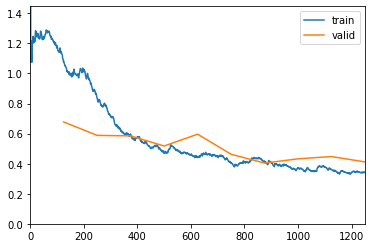

In [553]:
random_seed(1,True)
learn.fit_one_cycle(10, max_lr=slice(3e-03))

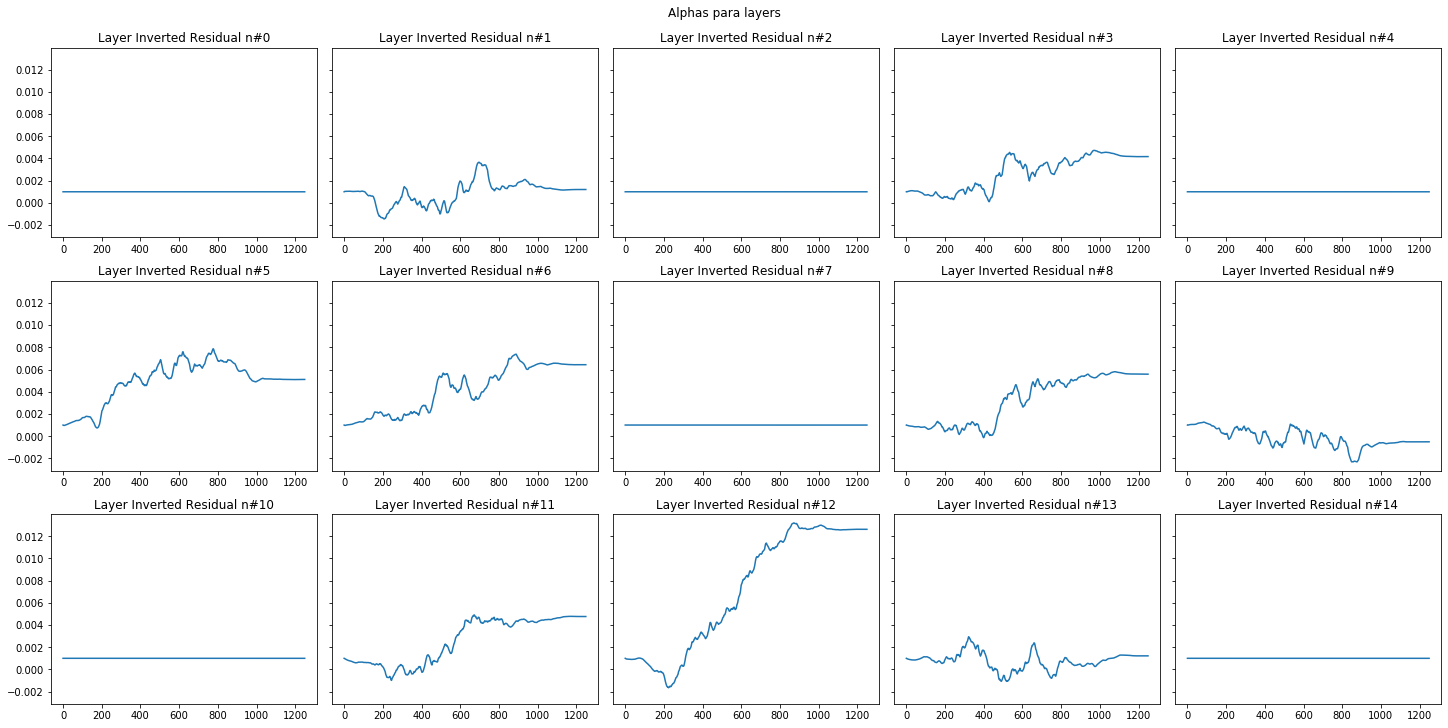

In [566]:
fig,axs = plt.subplots(3,5,figsize=(20,10), constrained_layout=True, sharey=True)

fig.suptitle('Alphas para layers')

for i in range(15):
    axs[i//5][i%5].set_title(f"Layer Inverted Residual n#{i}")
    axs[i//5][i%5].plot(learn.alphas.stats[0][i])
    